In [1]:
import pandas as pd
import numpy as np
import os

from matplotlib import pyplot as plt

from eda_utils import display_img_with_mask

In [2]:
instances_df = pd.read_csv('defect_instances.csv', index_col=0)
instances_df

,ImageId,ClassId,instance_center_x,instance_min_x,instance_max_x,instance_std_x
0,ac4ba5c1a.jpg,3,1227.626435,1201,1256,12.087398
1,ac4ba5c1a.jpg,3,1378.553672,1374,1383,2.052613
2,ac4ba5c1a.jpg,3,1358.213191,1339,1380,8.872769
3,ac4ba5c1a.jpg,3,1353.812325,1344,1367,5.448107
4,ac4ba5c1a.jpg,3,1389.486034,1385,1395,2.495488
...,...,...,...,...,...,...
148,4ef21d9b7.jpg,3,598.410367,590,608,4.172322
149,97bf2a97c.jpg,1,70.753304,61,80,5.235294
150,97bf2a97c.jpg,1,933.511327,924,943,5.322666
151,97bf2a97c.jpg,1,1202.360695,1189,1214,6.219900


count     153.000000
mean       80.163399
std       172.171520
min         0.000000
25%        19.000000
50%        27.000000
75%        53.000000
max      1180.000000
Name: instance_size, dtype: float64

0.90    145.00
0.95    314.80
0.99    944.04
Name: instance_size, dtype: float64

<AxesSubplot:>

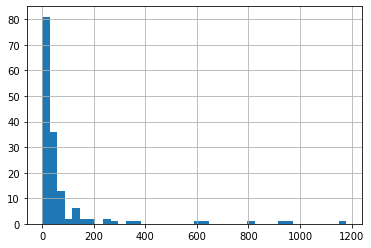

In [3]:
instances_df['instance_size'] = instances_df.instance_max_x - instances_df.instance_min_x
display(instances_df.instance_size.describe())
display(instances_df.instance_size.quantile([.9, .95, .99]))
instances_df.instance_size.hist(bins=40)

In [4]:
%%time

WINDOW_SIZE = 150

print(f'WINDOW_SIZE={WINDOW_SIZE}')

def get_overlapping_instances(row, df, window_size=256):
    """
    Given a particular row, a dataframe, and a window size, computes the instances that
    would appear in a window centered around the row's instance with a certain width.
    Only considers the x-axis.
    
    df: A dataframe containing all instances
    window_size: A clustering parameter.
    
    returns: The indices of instances that would appear in a window centered around the row's instance.
    """
    hw = window_size // 2
    extra = window_size % 2
    window_min, window_max = row.instance_center_x - hw, row.instance_center_x + hw + extra
    mask = (window_min < df.instance_min_x) & (df.instance_min_x < window_max)
    mask |= (window_min < df.instance_max_x) & (df.instance_max_x < window_max)
    mask |= (df.instance_min_x < window_min) & (window_max < df.instance_max_x)
    mask &= df.ImageId == row.ImageId
    return df[mask].index

instances_df['overlapping_instances'] = instances_df.apply(lambda row: get_overlapping_instances(row, instances_df, window_size=WINDOW_SIZE), axis=1)
instances_df['num_instances'] = instances_df['overlapping_instances'].apply(lambda x: len(x))
instances_df

WINDOW_SIZE=150
CPU times: user 539 ms, sys: 2.58 ms, total: 541 ms
Wall time: 534 ms


,ImageId,ClassId,instance_center_x,instance_min_x,instance_max_x,instance_std_x,instance_size,overlapping_instances,num_instances
0,ac4ba5c1a.jpg,3,1227.626435,1201,1256,12.087398,55,"Int64Index([0], dtype='int64')",1
1,ac4ba5c1a.jpg,3,1378.553672,1374,1383,2.052613,9,"Int64Index([1, 2, 3, 4], dtype='int64')",4
2,ac4ba5c1a.jpg,3,1358.213191,1339,1380,8.872769,41,"Int64Index([1, 2, 3, 4], dtype='int64')",4
3,ac4ba5c1a.jpg,3,1353.812325,1344,1367,5.448107,23,"Int64Index([1, 2, 3, 4], dtype='int64')",4
4,ac4ba5c1a.jpg,3,1389.486034,1385,1395,2.495488,10,"Int64Index([1, 2, 3, 4], dtype='int64')",4
...,...,...,...,...,...,...,...,...,...
148,4ef21d9b7.jpg,3,598.410367,590,608,4.172322,18,"Int64Index([145, 147, 148], dtype='int64')",3
149,97bf2a97c.jpg,1,70.753304,61,80,5.235294,19,"Int64Index([149], dtype='int64')",1
150,97bf2a97c.jpg,1,933.511327,924,943,5.322666,19,"Int64Index([150], dtype='int64')",1
151,97bf2a97c.jpg,1,1202.360695,1189,1214,6.219900,25,"Int64Index([151], dtype='int64')",1


count    153.000000
mean       2.209150
std        1.749638
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        8.000000
Name: num_instances, dtype: float64

<AxesSubplot:>

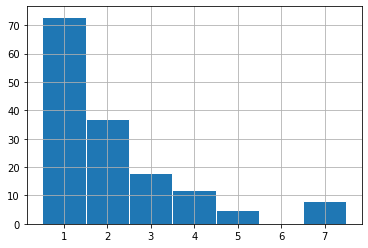

In [5]:
display(instances_df.num_instances.describe())
instances_df.num_instances.hist(bins=instances_df.num_instances.max() - 1, align='left', edgecolor='white')

In [6]:
%%time

def all_instances_fit_in_window(row, df, max_size=145):
    """
    Given a row and a dataframe of instances, determines whether the previously computed overlapping instances
    are all within `tol` distance of the row's instance center.
    """
    overlapping = df.loc[row.overlapping_instances]
    return np.all(overlapping.instance_size <= max_size)

instances_df['all_instances_fit_in_window'] = instances_df.apply(
    lambda row: all_instances_fit_in_window(row, instances_df),
    axis=1
)
instances_df

CPU times: user 198 ms, sys: 24.9 ms, total: 223 ms
Wall time: 206 ms


,ImageId,ClassId,instance_center_x,instance_min_x,instance_max_x,instance_std_x,instance_size,overlapping_instances,num_instances,all_instances_fit_in_window
0,ac4ba5c1a.jpg,3,1227.626435,1201,1256,12.087398,55,"Int64Index([0], dtype='int64')",1,True
1,ac4ba5c1a.jpg,3,1378.553672,1374,1383,2.052613,9,"Int64Index([1, 2, 3, 4], dtype='int64')",4,True
2,ac4ba5c1a.jpg,3,1358.213191,1339,1380,8.872769,41,"Int64Index([1, 2, 3, 4], dtype='int64')",4,True
3,ac4ba5c1a.jpg,3,1353.812325,1344,1367,5.448107,23,"Int64Index([1, 2, 3, 4], dtype='int64')",4,True
4,ac4ba5c1a.jpg,3,1389.486034,1385,1395,2.495488,10,"Int64Index([1, 2, 3, 4], dtype='int64')",4,True
...,...,...,...,...,...,...,...,...,...,...
148,4ef21d9b7.jpg,3,598.410367,590,608,4.172322,18,"Int64Index([145, 147, 148], dtype='int64')",3,True
149,97bf2a97c.jpg,1,70.753304,61,80,5.235294,19,"Int64Index([149], dtype='int64')",1,True
150,97bf2a97c.jpg,1,933.511327,924,943,5.322666,19,"Int64Index([150], dtype='int64')",1,True
151,97bf2a97c.jpg,1,1202.360695,1189,1214,6.219900,25,"Int64Index([151], dtype='int64')",1,True


In [7]:
instances_df['all_instances_fit_in_window'].value_counts()

True     132
False     21
Name: all_instances_fit_in_window, dtype: int64

In [8]:
%%time

def all_instances_approx_centered(row, df, tol=10):
    """
    Given a row and a dataframe of instances, determines whether the previously computed overlapping instances
    are all within `tol` distance of the row's instance center.
    """
    overlapping = df.loc[row.overlapping_instances]
    appx_center_min = row.instance_center_x - tol
    appx_center_max = row.instance_center_x + tol
    return np.all((appx_center_min < overlapping.instance_center_x) &
                 (overlapping.instance_center_x < appx_center_max))

tol = instances_df.instance_std_x.mean() * 2
print(f'tol={tol}')
instances_df['all_overlapping_appx_centered'] = instances_df.apply(
    lambda row: all_instances_approx_centered(row, instances_df, tol=tol),
    axis=1
)
instances_df

tol=41.61079313270115
CPU times: user 266 ms, sys: 9.33 ms, total: 276 ms
Wall time: 267 ms


,ImageId,ClassId,instance_center_x,instance_min_x,instance_max_x,instance_std_x,instance_size,overlapping_instances,num_instances,all_instances_fit_in_window,all_overlapping_appx_centered
0,ac4ba5c1a.jpg,3,1227.626435,1201,1256,12.087398,55,"Int64Index([0], dtype='int64')",1,True,True
1,ac4ba5c1a.jpg,3,1378.553672,1374,1383,2.052613,9,"Int64Index([1, 2, 3, 4], dtype='int64')",4,True,True
2,ac4ba5c1a.jpg,3,1358.213191,1339,1380,8.872769,41,"Int64Index([1, 2, 3, 4], dtype='int64')",4,True,True
3,ac4ba5c1a.jpg,3,1353.812325,1344,1367,5.448107,23,"Int64Index([1, 2, 3, 4], dtype='int64')",4,True,True
4,ac4ba5c1a.jpg,3,1389.486034,1385,1395,2.495488,10,"Int64Index([1, 2, 3, 4], dtype='int64')",4,True,True
...,...,...,...,...,...,...,...,...,...,...,...
148,4ef21d9b7.jpg,3,598.410367,590,608,4.172322,18,"Int64Index([145, 147, 148], dtype='int64')",3,True,True
149,97bf2a97c.jpg,1,70.753304,61,80,5.235294,19,"Int64Index([149], dtype='int64')",1,True,True
150,97bf2a97c.jpg,1,933.511327,924,943,5.322666,19,"Int64Index([150], dtype='int64')",1,True,True
151,97bf2a97c.jpg,1,1202.360695,1189,1214,6.219900,25,"Int64Index([151], dtype='int64')",1,True,True


In [9]:
instances_df.all_overlapping_appx_centered.value_counts()

True     116
False     37
Name: all_overlapping_appx_centered, dtype: int64

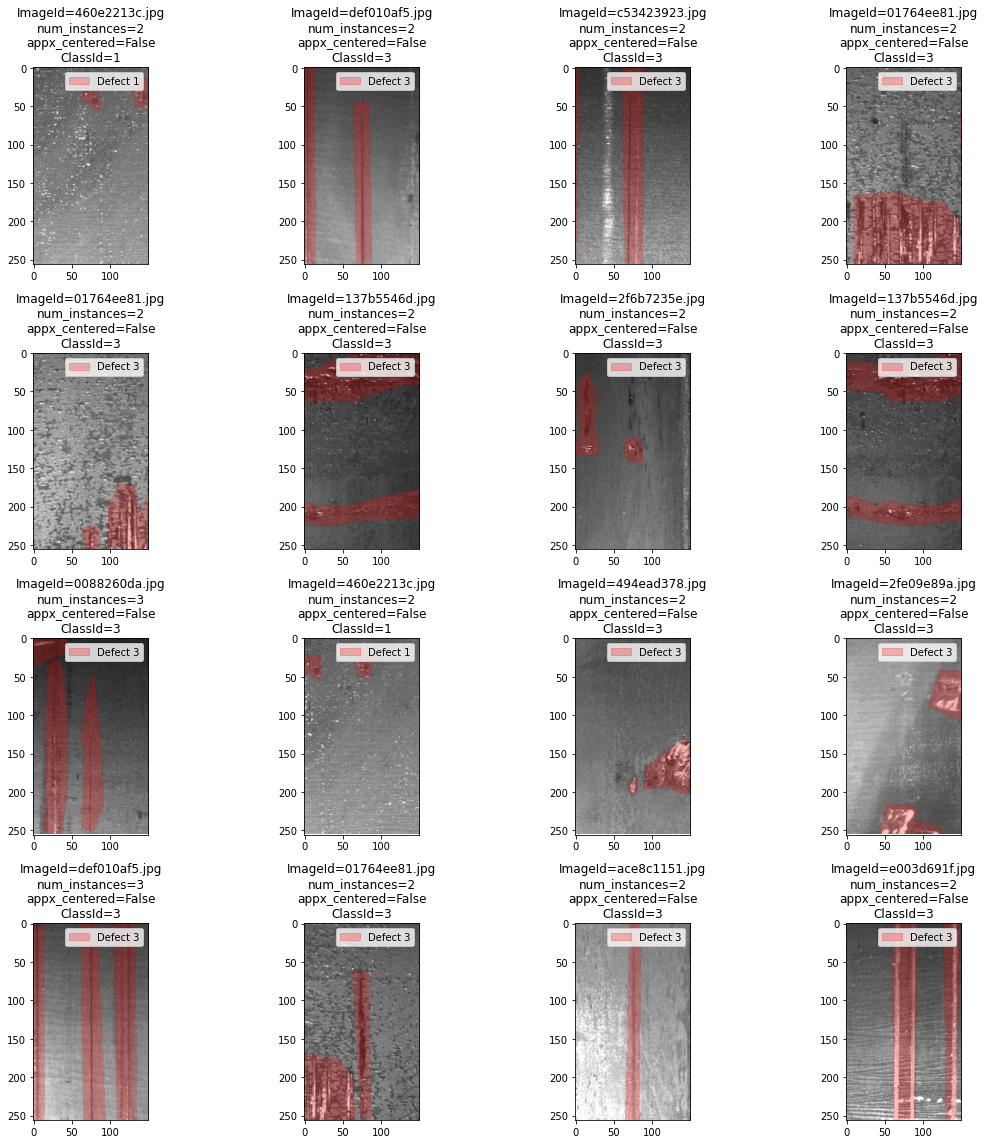

In [10]:
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

train_df = pd.read_csv('../data/train.csv')
mask = instances_df.all_overlapping_appx_centered == False
for ax, row in zip(axes.flat, instances_df[mask].sample(frac=1, random_state=42).itertuples()):
    ax.set_title(f'ImageId={row.ImageId}\nnum_instances={row.num_instances}\nappx_centered=False\nClassId={row.ClassId}')
    hw = WINDOW_SIZE // 2
    x_min, x_max = int(row.instance_center_x - hw), int(row.instance_center_x + hw)
    if x_min < 0:
        print(f'x_min={x_min} is off the edge, setting to 0')
        x_min = 0
    if x_max > 1600:
        print(f'x_max={x_max} is off the edge, setting to 1600')
        x_max = 1600
    display_img_with_mask(train_df, row.ImageId, x_window=(x_min, x_max), ax=ax)

plt.tight_layout()

x_min=-54 is off the edge, setting to 0


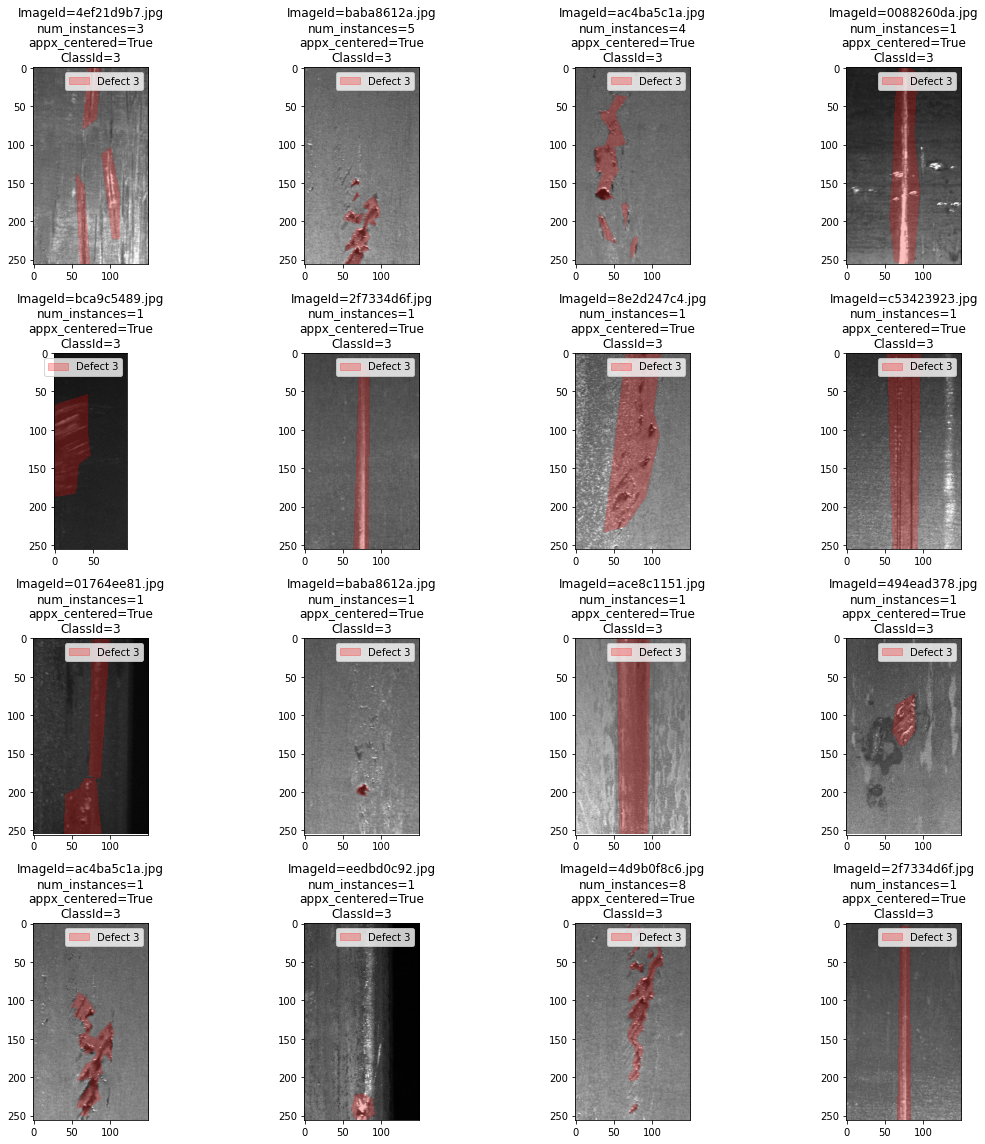

In [11]:
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

train_df = pd.read_csv('../data/train.csv')
mask = instances_df.all_overlapping_appx_centered == True
mask &= instances_df.all_instances_fit_in_window
for ax, row in zip(axes.flat, instances_df[mask].sample(frac=1, random_state=42).itertuples()):
    ax.set_title(f'ImageId={row.ImageId}\nnum_instances={row.num_instances}\nappx_centered=True\nClassId={row.ClassId}')
    hw = WINDOW_SIZE // 2
    x_min, x_max = int(row.instance_center_x - hw), int(row.instance_center_x + hw)
    if x_min < 0:
        print(f'x_min={x_min} is off the edge, setting to 0')
        x_min = 0
    if x_max > 1600:
        print(f'x_max={x_max} is off the edge, setting to 1600')
        x_max = 1600
    display_img_with_mask(train_df, row.ImageId, x_window=(x_min, x_max), ax=ax)

plt.tight_layout()

In [12]:
instances_df[instances_df.all_overlapping_appx_centered].describe()

,ClassId,instance_center_x,instance_min_x,instance_max_x,instance_std_x,instance_size,num_instances
count,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000
mean,2.706897,884.974585,847.077586,923.750000,19.800446,76.672414,2.206897
std,0.710386,411.202444,421.373740,421.010975,46.685441,178.638122,1.997900
min,1.000000,20.919536,0.000000,47.000000,0.000000,0.000000,1.000000
25%,3.000000,612.728390,535.750000,635.000000,4.609188,18.000000,1.000000
50%,3.000000,930.119359,871.500000,1093.500000,6.430791,25.000000,1.000000
75%,3.000000,1223.750000,1203.750000,1245.000000,12.461494,49.500000,3.000000
max,3.000000,1503.028318,1468.000000,1576.000000,312.843510,1180.000000,8.000000


In [13]:
mask = instances_df.all_overlapping_appx_centered & instances_df.all_instances_fit_in_window
instances_df[mask].ClassId.value_counts()

3    89
1    17
Name: ClassId, dtype: int64

In [14]:
instances_df['window_size'] = WINDOW_SIZE
save_cols = [
    'ImageId',
    'ClassId',
    'instance_center_x',
    'window_size',
]
mask = instances_df.all_overlapping_appx_centered & instances_df.all_instances_fit_in_window
instances_df.loc[mask, save_cols].to_csv('centered_instances.csv')